In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from functools import partial
from scipy.stats import f, ncf
from sklearn.metrics import r2_score
from tqdm.notebook import trange
from utils import *
from estimators import ClusteredSegmentation

# Simluation

In [10]:
def sim(p, n, sample_name):
    test_result = []
    sample = sample_name
    rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
    X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    start = rg.config.parameter_size + 10
    end   = 5
    n = start
    cluster = ClusteredSegmentation(n_clusters = n)
    for i in range(start- end + 1, leave = False):
        cluster.fit(X, y)
        tau = cluster.tau_metric
        test_result.append((tau.r_sqr, tau.tau_est, tau.tau_LB, tau.q, tau.r_sqf, sample, start - 10))
        n -= 1
        cluster.set_params(n_clusters = n)
    return test_result

In [11]:
from joblib import Parallel, delayed
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 10_000, sample_name = f'sample_{i}') for i in range(10)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  4.2min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.4min finished


In [12]:
columns = ['rsq','tau','tau_lb', 'num_segments', 'rsq_full', 'sample', 'true_segment']
test_result = res[0]
for i in range(1, 10):
    test_result = test_result + res[i]
result = pd.DataFrame(test_result, columns = columns)

In [13]:
result.true_segment.unique()

array([151, 157, 150, 134, 171, 172, 280, 189, 209])

In [14]:
result.rsq_full.unique()

array([0.77028132, 0.32686118, 0.72639966, 0.40413226, 0.79886073,
       0.60306447, 0.91980434, 0.8356384 , 0.85441663, 0.71034478])

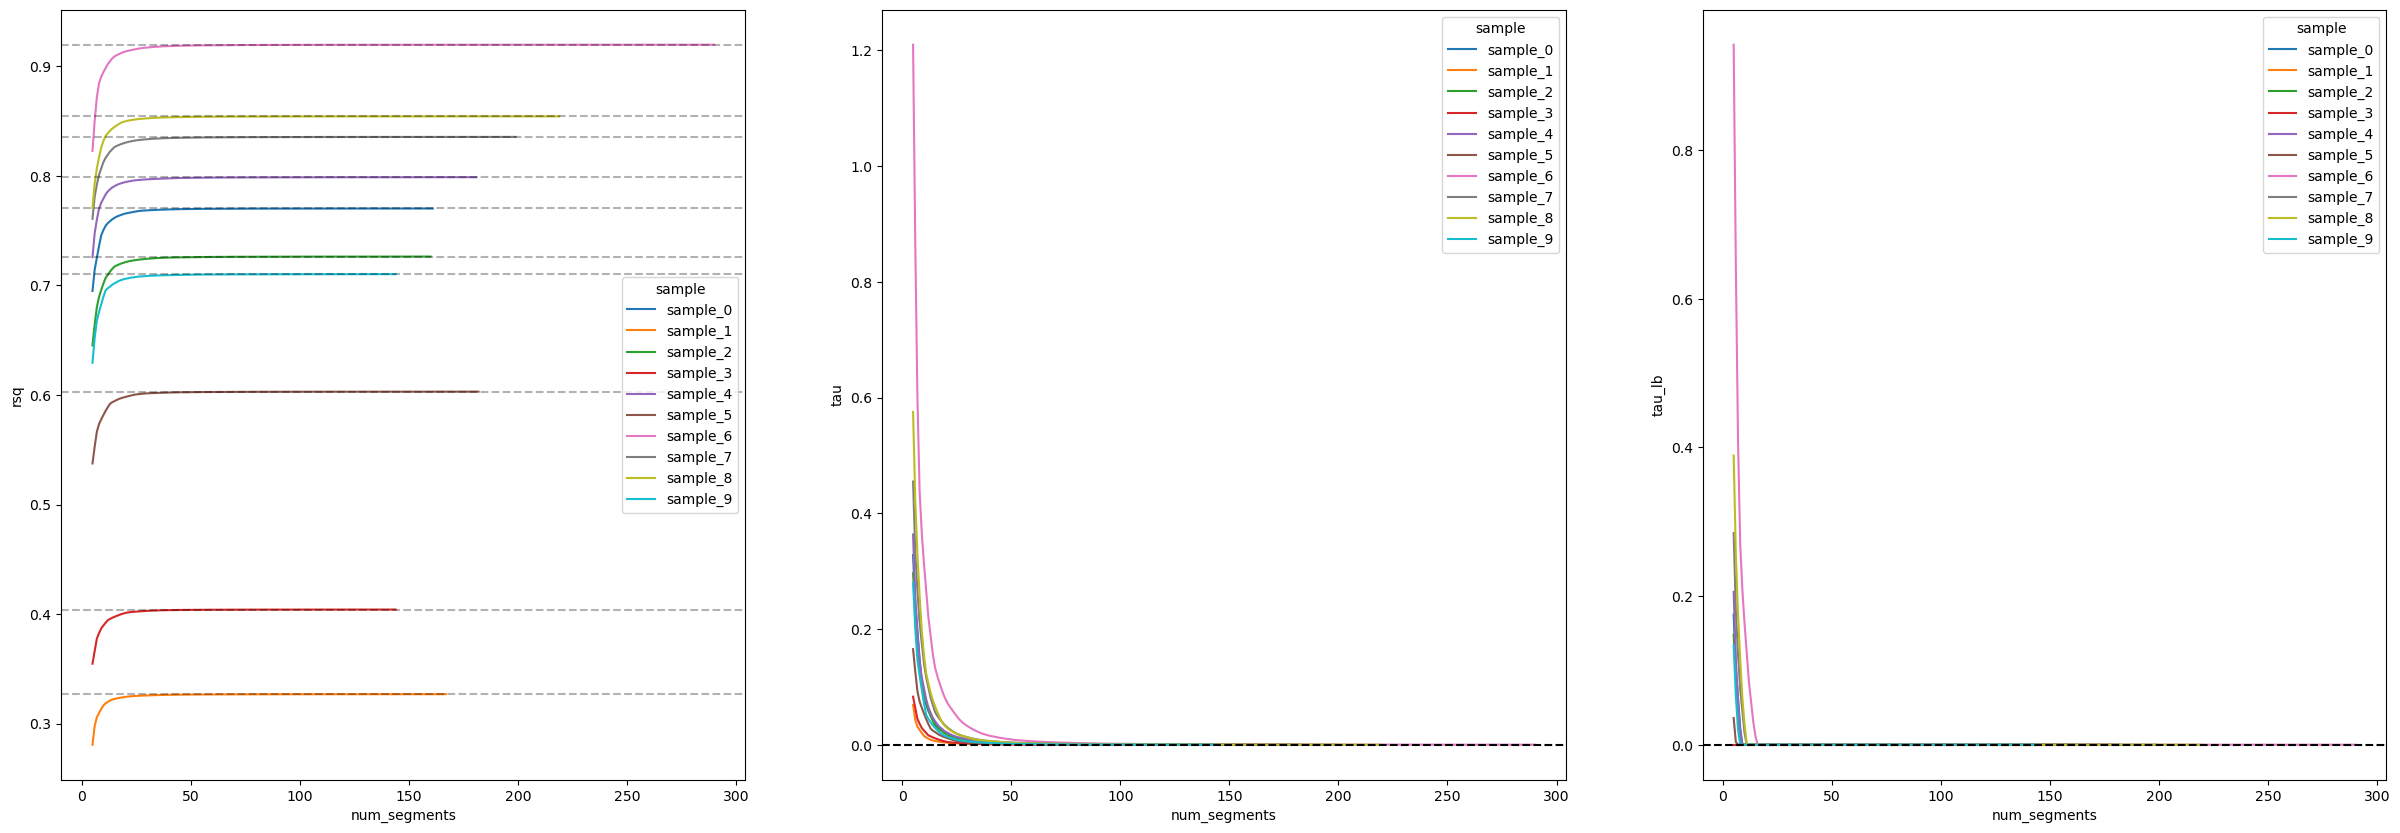

  0%|          | 0/195 [00:00<?, ?it/s]


In [18]:
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
sns.lineplot(data = result, x = 'num_segments', y = 'rsq', hue = 'sample', ax = ax[0])
sns.lineplot(data = result, x = 'num_segments', y = 'tau', hue = 'sample', ax = ax[1])
sns.lineplot(data = result, x = 'num_segments', y = 'tau_lb', hue = 'sample', ax = ax[2])
for rsq_full in result.rsq_full.unique():
    ax[0].axhline(rsq_full, c = 'black', linestyle = '--', alpha = .3)
ax[1].axhline(0, c = 'black', linestyle = '--')
ax[2].axhline(0, c = 'black', linestyle = '--')
plt.savefig('result.png')
plt.show()

# Simulation 2 : Performance of the model with test data

In this simulation, we tested how well the model performs with respect to the testing dataset. After drawing random datasets, they are split into train and test dataset with 4:1 ratio. The models are fit with the train dataset, and $R^2$ is obtained not only from the train but also from the test dataset. 

In [655]:
from sklearn.model_selection import train_test_split

In [665]:
def sim(p, n):
    rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
    X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  .20)
    cluster = ClusteredSegmentation(n_clusters = 10)
    cluster.fit(X, y)
    tau = cluster.tau_metric
    y_pred_exist = []
    y_test_exist = []
    for i, x in enumerate(X_test.reshape(-1)):
        try:
            y_pred_exist.append(cluster.predict(x))
            y_test_exist.append(y_test[i][0])
        except:
            pass
    test_r2 = r2_score(y_test_exist, y_pred = y_pred_exist)
    return rg.config.parameter_size, tau.r_sqf, tau.r_sqr, tau.tau_est, test_r2

In [667]:
from joblib import Parallel, delayed
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 12_500) for i in range(500)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


In [671]:
result = pd.DataFrame(res, columns = ['parameter_size','r2f','r2r','tau_est','test_r2'])

In [674]:
result = result.sort_values('r2f', ascending=False).reset_index(drop = True)

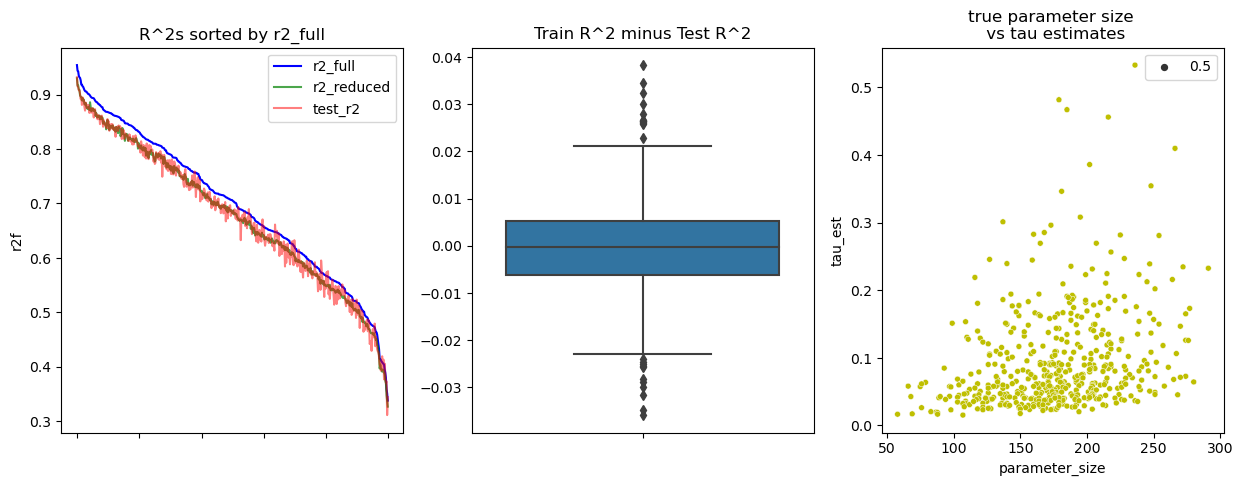

In [721]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
sns.lineplot(data = result, x = result.index, y = 'r2f', color = 'blue', ax = ax1, label = 'r2_full')
sns.lineplot(data = result, x = result.index, y = 'r2r', color = 'green', alpha = .7, ax = ax1, label = 'r2_reduced')
sns.lineplot(data = result, x = result.index, y = 'test_r2', color = 'red', alpha = .5, ax = ax1, label= 'test_r2')
sns.boxplot(y = result.r2r - result.test_r2, ax = ax2)
sns.scatterplot(data = result, x = 'parameter_size', y = 'tau_est', size = .5, color = 'y', ax = ax3)
ax1.set_xticklabels("")
ax1.legend()
ax1.set_title('R^2s sorted by r2_full')
ax2.set_title('Train R^2 minus Test R^2')
ax3.set_title("true parameter size \n vs tau estimates")
plt.show()

# Unseen Pairs

# Performance on testing dataset (maybe including unseen pairs)